# Data cleaning and preprocessing

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

# 1. Normalization

In [1]:
file_name = "../data_set/cultural_data/clean_data/clean_data.csv"
WVS_questions = "../data_set/cultural_data/WVS_topics_ questions.csv"
country_name = "../data_set/cultural_data/clean_data/country_code.csv"

In [81]:
import pandas as pd
import numpy as np

data = pd.read_csv(file_name,header=None)
questions = pd.read_csv(WVS_questions,header=None)
country = pd.read_csv(country_name,header=None)

In [82]:
questions.columns = ["title","min","max","type","norm_type"]
data.columns = questions["title"]
country.columns = ["name"]
print(data)
print(questions)

title   V2  V4  V5  V6  V7  V8  V9  V10  V11  V12  ...   V247  V248  V249  \
0       12   1   1   1  -2   1   1    2    1    1  ...  12001   7.0    24   
1       12   1   2   3   4   2   2    2    2    2  ...  12001   7.0    25   
2       12   1   3   2   4   2   1    2    2    2  ...  12002   5.0    18   
3       12   1   1   3   4   3   1    2    1    2  ...  12002   6.0    14   
4       12   1   1   1   2   1   1    1    3    2  ...  12002   3.0     8   
...    ...  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...    ...   ...   ...   
90345  716   1   3   2   4   1   1    3    3    2  ...    405   4.0    16   
90346  716   1   1   1   3   1   1    3    1    2  ...    405   5.0    18   
90347  716   1   2   1   3   1   1    3    3    2  ...    405   2.0     9   
90348  716   1   2   2   3   1   1    2    2    2  ...    405   5.0    32   
90349  716   1   2   2   2   2   1    2    2    2  ...    405   4.0    15   

title  V250  V251  V252  V253   V254  V255  V258  
0         1     2     2 

In [104]:
# Processing country names
new = country['name'].str.split("'", n = 1, expand = True)
new[1] = new[1].str.replace("'","")
new[0] = new[0].astype(int)
country['index'], country['name'] = new[0],new[1]
print(country)

                    name  index
0       Missing; Unknown     -5
1    Not asked in survey     -4
2         Not applicable     -3
3              No answer     -2
4              Dont know     -1
..                   ...    ...
197               Bosnia    914
198               Kosovo    915
199     Flanders-Belgium    916
200        Israel (Jews)    917
201       Israel (Arabs)    918

[202 rows x 2 columns]


In [108]:
country_data = data.groupby(["V2"]).count().sort_values(["V4"],ascending=False)

country_df = pd.DataFrame(columns=["name","index","respondents"])
country_df["index"] = country_data.index
country_df["respondents"] = np.array(country_data['V4'])

country_df["name"] = [country[country['index'] == x]['name'].iloc[0] for x in country_df["index"]]

print(country_df)
print(country_df["respondents"].sum(),len(data))

                   name  index  respondents
0                 India    356         5659
1          South Africa    710         3531
2                Russia    643         2500
3                 Japan    392         2443
4                 China    156         2300
5         United States    840         2232
6                 Libya    434         2131
7               Germany    276         2046
8                Mexico    484         2000
9             Singapore    702         1972
10          Netherlands    528         1902
11              Nigeria    566         1759
12               Turkey    792         1605
13                Ghana    288         1552
14              Belarus    112         1535
15              Estonia    233         1533
16               Rwanda    646         1527
17                Egypt    818         1523
18             Colombia    170         1512
19              Romania    642         1503
20              Ukraine    804         1500
21           Kazakhstan    398  

In [109]:
data = data.drop(columns=["V144","V254","V247"])
data = data.drop(columns=["V2","V241","V251","V252","V258"])

In [14]:
# Deal with not applicable value
from sklearn.impute import SimpleImputer

# Combine columns of invalid value
# ls = [[],[],[]]
# ls[0] = ['V44','V44_ES']
# ls[1] = ['V125_'+str(i) for i in range(18)]
# ls[2] = ['V215_'+str(i) for i in range(1,19)]
# name = ['V44','V125','V215']

# for i in range(len(ls)):
#     col = [0]*len(data)
#     for j in range(len(data)):
#         column = ls[i]
#         row = data[column].iloc[j]
#         for k in range(len(row)):
#             if row[k] != -4:
#                 col[j] = row[k]
#     print(column)
#     index = df.columns.get_loc(column[0]) + i
#     n = name[i]
#     data = data.drop(columns=column)
#     data.insert(index,n,col)
# print(df['V125'])

# Impute negative value elsewhere
imp = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
df = pd.DataFrame(imp.fit_transform(data))
df.columns=data.columns
df.index=data.index
print(df.columns)

# Normalize the data
for column in df.columns:
    minimum = int(df[column].min())
    maximum = int(df[column].max())
    print(questions[questions["title"]==column].norm_type)
    norm_type = list(questions[questions["title"]==column].norm_type)[0]
    
    if norm_type == 2:
        for i in range(minimum,maximum+1):
            index = df.columns.get_loc(column) + i
            name = column+"_"+str(i)
            col = [0]*len(df[column])
            for j in range(len(df[column])):
                col[j] = 1 if df[column][j] == i else 0
            df.insert(index,name,col)
        df = df.drop(columns=[column])

    elif norm_type == 1:
        df[column] = df[column].apply(lambda x: (x-minimum)/(maximum-minimum))
        
    elif norm_type == 3:
        df[column] = df[column].apply(lambda x: 1-(x-minimum)/(maximum-minimum))
        
print(df["V57_1"])

Index(['V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       ...
       'V242', 'V243', 'V244', 'V245', 'V246', 'V248', 'V249', 'V250', 'V253',
       'V255'],
      dtype='object', name='title', length=304)
1    1
Name: norm_type, dtype: int64
2    1
Name: norm_type, dtype: int64
3    1
Name: norm_type, dtype: int64
4    1
Name: norm_type, dtype: int64
5    1
Name: norm_type, dtype: int64
6    1
Name: norm_type, dtype: int64
7    3
Name: norm_type, dtype: int64
8    3
Name: norm_type, dtype: int64
9    3
Name: norm_type, dtype: int64
10    3
Name: norm_type, dtype: int64
11    3
Name: norm_type, dtype: int64
12    3
Name: norm_type, dtype: int64
13    3
Name: norm_type, dtype: int64
14    3
Name: norm_type, dtype: int64
15    3
Name: norm_type, dtype: int64
16    3
Name: norm_type, dtype: int64
17    3
Name: norm_type, dtype: int64
18    3
Name: norm_type, dtype: int64
19    3
Name: norm_type, dtype: int64
20    1
Name: norm_type, dtype: int64
21    3
Name: norm_type,

210    3
Name: norm_type, dtype: int64
211    3
Name: norm_type, dtype: int64
212    3
Name: norm_type, dtype: int64
213    3
Name: norm_type, dtype: int64
214    3
Name: norm_type, dtype: int64
215    3
Name: norm_type, dtype: int64
216    3
Name: norm_type, dtype: int64
217    3
Name: norm_type, dtype: int64
218    3
Name: norm_type, dtype: int64
219    1
Name: norm_type, dtype: int64
220    1
Name: norm_type, dtype: int64
221    1
Name: norm_type, dtype: int64
222    1
Name: norm_type, dtype: int64
223    1
Name: norm_type, dtype: int64
224    1
Name: norm_type, dtype: int64
225    1
Name: norm_type, dtype: int64
226    1
Name: norm_type, dtype: int64
227    1
Name: norm_type, dtype: int64
228    1
Name: norm_type, dtype: int64
229    1
Name: norm_type, dtype: int64
230    1
Name: norm_type, dtype: int64
231    1
Name: norm_type, dtype: int64
232    1
Name: norm_type, dtype: int64
233    1
Name: norm_type, dtype: int64
234    1
Name: norm_type, dtype: int64
235    1
Name: norm_type,

In [15]:
# test = pd.DataFrame([[1,2],[2,3],[1,3],[1,1]])
# test.columns = ['a','b']
# print(test)
# print(list(test[test["a"]==2].b)[0])
# mini = 1
# maxi = 3
# for i in range(mini,maxi+1):
#     index = test.columns.get_loc('b') + i
#     name = 'b'+ str(i)
#     col = [0]*len(test['b'])
#     for j in range(len(test['b'])):
#         col[j] = 1 if test['b'][j] == i else 0
#     test.insert(index,name,col)
# test = test.drop(columns=['b'])
# print(test)
# print(data['V57'])

print("hello")
test = pd.DataFrame([[-4,1,-4],[3,-4,3],[1,-4,1]])
ls = [['V1_1','V1_2']]
name = ['V1']
test.columns = ['V1_1','V1_2','V2']
for i in range(len(ls)):
    col = [0]*len(test)
    for j in range(len(test)):
        column = ls[i]
        row = test[column].iloc[j]
        for k in range(len(row)):
            if row[k] != -4:
                col[j] = row[k]
    index = test.columns.get_loc(column[0]) + i
    n = name[i]
    test = test.drop(columns=column)
    test.insert(index,n,col)
    print(index,n,col)
print(test)
print(data)

hello
0 V1 [1, 3, 1]
   V1  V2
0   1  -4
1   3   3
2   1   1
title  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  ...  V242  V243  V244  \
0       1   1   1  -2   1   1    2    1    1    1  ...    21     2     2   
1       1   2   3   4   2   2    2    2    2    1  ...    24     2     2   
2       1   3   2   4   2   1    2    2    2    2  ...    26     2     2   
3       1   1   3   4   3   1    2    1    2    2  ...    28     2     2   
4       1   1   1   2   1   1    1    3    2    1  ...    35     2     2   
...    ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   ...   ...   ...   
90345   1   3   2   4   1   1    3    3    2    1  ...    41     2     2   
90346   1   1   1   3   1   1    3    1    2    1  ...    27     2     2   
90347   1   2   1   3   1   1    3    3    2    1  ...    37     2     2   
90348   1   2   2   3   1   1    2    2    2    1  ...    32     2     2   
90349   1   2   2   2   2   1    2    2    2    1  ...    31     2     2   

title  V245  V246  V248  V

As we see from the above experiment, the best fitting line does not really help us to predict the value of $y$: the linear combination of features such as $\mathbf{wx} + b$ gives a continuous result
that spans from minus infinity to plus infinity, while $y$ has only two possible values.

We also see that the $SSR$ would not be a good objective function for fitting this line - no matter how you change the line parameters, the SSR will always remain very high.

3
4
5
6
7
8
9


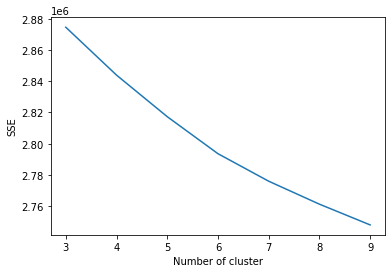

In [159]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
for i in range(3,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df)
    sse[i] = kmeans.inertia_ 
    print(i)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
